# Twitch Network Analysis - English/British Streamers

This notebook analyzes the Twitch ENGB network dataset and compares it with artificial networks (Erdős–Rényi and Barabási–Albert models). We'll examine network properties, visualize distributions, and identify important nodes in the network.

## Project Overview

- **Dataset**: Twitch user-user networks of English/British streamers
- **Nodes**: Twitch users
- **Edges**: Mutual friendships between users
- **Features**: Based on games played/liked, location, and streaming habits
- **Target Variable**: Whether a streamer uses explicit language (binary classification)

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Set plot style
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 1. Data Loading and Preprocessing

First, we'll load the datasets and examine their structure.

In [2]:
# Load the datasets
edges = pd.read_csv('musae_ENGB_edges.csv')
targets = pd.read_csv('musae_ENGB_target.csv')
with open('musae_ENGB_features.json') as f:
    features_json = json.load(f)

print(f"Edges shape: {edges.shape}")
print(f"Targets shape: {targets.shape}")
print(f"Number of features: {len(features_json)}")

print("\nEdges preview:")
print(edges.head())

print("\nTargets preview:")
print(targets.head())

print("\nFeatures (first entry):")
# Convert first entry to dict for better viewing
first_feature = list(features_json.keys())[0]
print(f"Features for node {first_feature}: {features_json[first_feature][:5]}...")

Edges shape: (35324, 2)
Targets shape: (7126, 6)
Number of features: 7126

Edges preview:
   from    to
0  6194   255
1  6194   980
2  6194  2992
3  6194  2507
4  6194   986

Targets preview:
          id  days  mature  views  partner  new_id
0   73045350  1459   False   9528    False    2299
1   61573865  1629    True   3615    False     153
2  171688860   411    True  46546    False     397
3  117338954   953    True   5863    False    5623
4  135804217   741    True   5594    False    5875

Features (first entry):
Features for node 3032: [2605, 1191, 357, 2120, 861]...


In [3]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) // nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName if hasattr(df, 'dataframeName') else 'Data'  # Added fallback
    df = df.dropna(axis='columns')  # Fixed: use axis parameter instead
    df = df[[col for col in df if df[col].nunique() > 1]]  # keep columns with >1 unique value
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()
    
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include=[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')  # Fixed: use axis parameter
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns with >1 unique value
    columnNames = list(df)
    if len(columnNames) > 10: # reduce number of columns for matrix inversion
        columnNames = columnNames[:10]
    df = df[columnNames]
    
    # Create scatter matrix
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    
    # Add correlation coefficients
    corrs = df.corr().values
    for i, j in zip(*np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], 
                         (0.8, 0.2), 
                         xycoords='axes fraction', 
                         ha='center', 
                         va='center', 
                         size=textSize)
    
    plt.suptitle('Scatter and Density Plot')
    plt.tight_layout()
    plt.show()

## Node Attribute Analysis
Exploring the distributions and correlations of streamer attributes


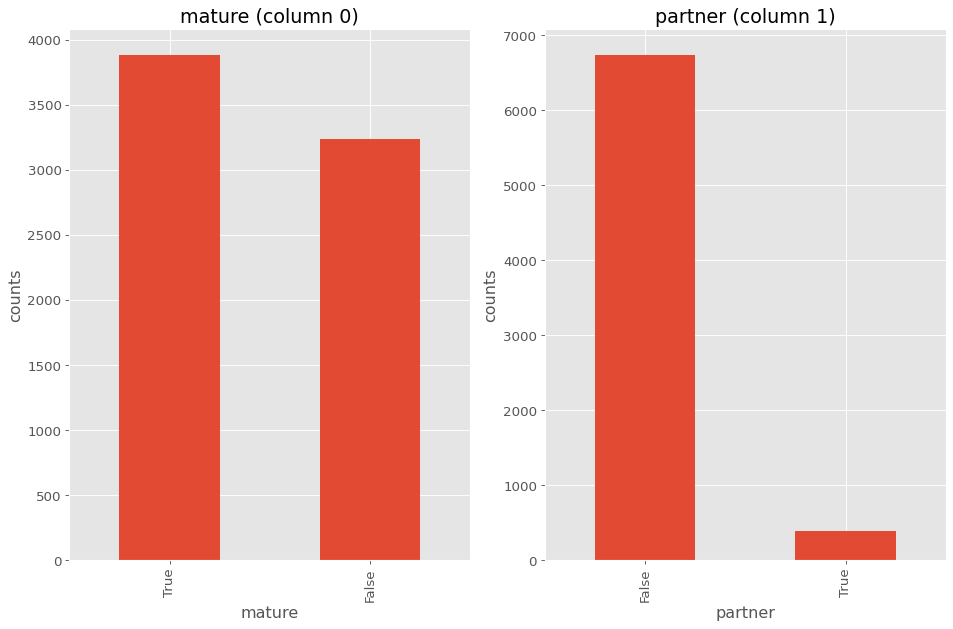

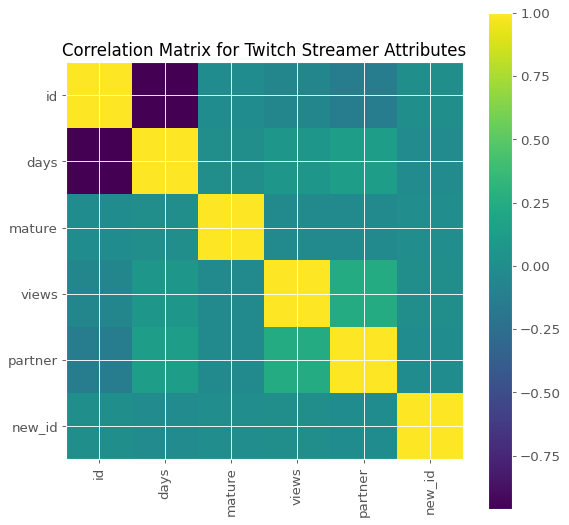

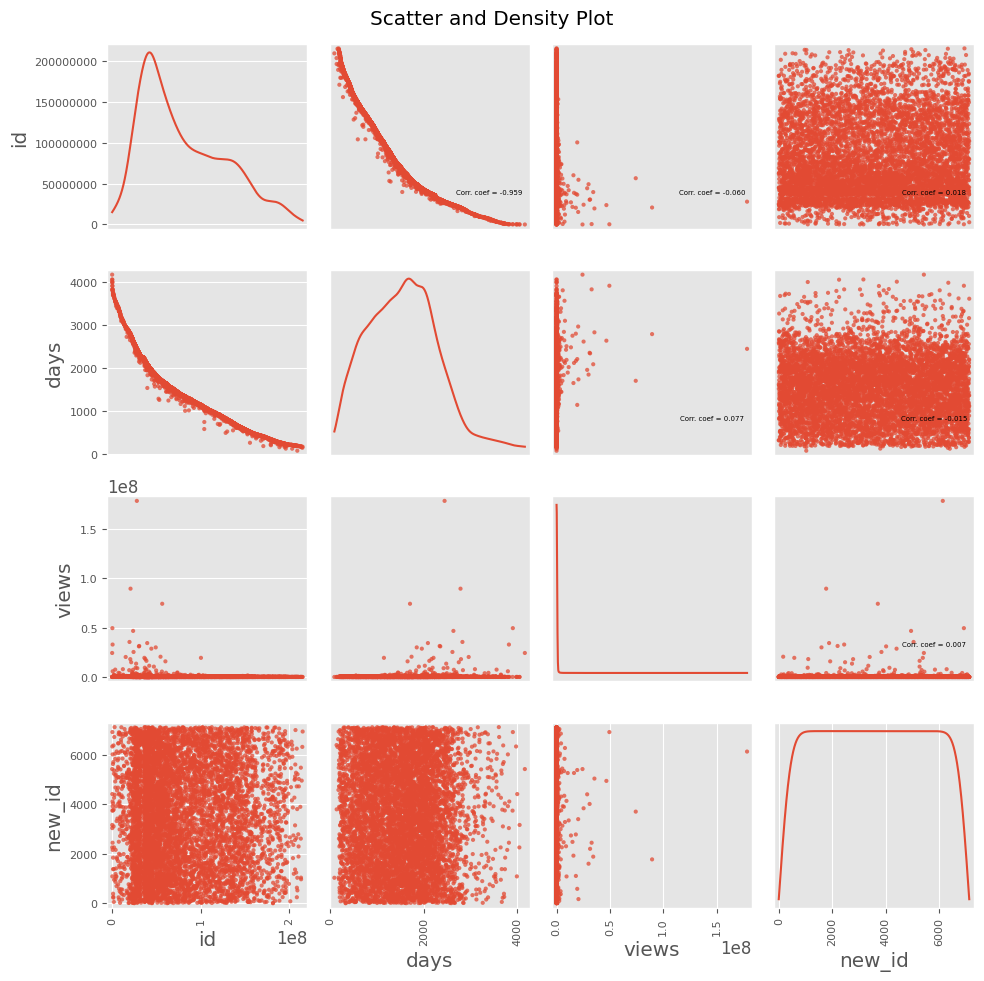

In [4]:
# Add to a new cell in the notebook, after data loading section
# Set up dataframe name for correlation plot
targets.dataframeName = 'Twitch Streamer Attributes'

# Add a new markdown section
print("## Node Attribute Analysis")
print("Exploring the distributions and correlations of streamer attributes")

# Plot distributions of streamer attributes
plotPerColumnDistribution(targets, 5, 3)  # Show first 5 attributes, 3 per row

# Plot correlation matrix
plotCorrelationMatrix(targets, 8)  # 8x8 inch graph

# Plot scatter matrix for numerical columns
plotScatterMatrix(targets, 10, 5)  # 10x10 inch plot, text size 5

## 2. Original Network Creation and Analysis

Create the original network using the edges data and compute basic network statistics.

In [5]:
# Create the original network
G_original = nx.from_pandas_edgelist(edges, 'from', 'to')

# Basic network information
print("Original Network Information")
print("-" * 50)
print(f"Number of nodes: {G_original.number_of_nodes()}")
print(f"Number of edges: {G_original.number_of_edges()}")
print(f"Network density: {nx.density(G_original):.6f}")

# Check for the largest connected component
largest_cc = max(nx.connected_components(G_original), key=len)
largest_cc_subgraph = G_original.subgraph(largest_cc)
print(f"Size of largest connected component: {len(largest_cc)} nodes ({len(largest_cc)/G_original.number_of_nodes()*100:.2f}% of the network)")

Original Network Information
--------------------------------------------------
Number of nodes: 7126
Number of edges: 35324
Network density: 0.001391
Size of largest connected component: 7126 nodes (100.00% of the network)


In [6]:
# Create a mapping from node IDs to user attributes
node_attributes = {}
for _, row in targets.iterrows():
    node_attributes[row['new_id']] = {
        'mature': row['mature'],
        'days': row['days'],
        'views': row['views'],
        'partner': row['partner']
    }

# Add node attributes to the graph
for node in G_original.nodes():
    if node in node_attributes:
        for attr, value in node_attributes[node].items():
            G_original.nodes[node][attr] = value

## 3. Creating Artificial Networks

We'll create two artificial networks:
1. Random network (Erdős–Rényi model)
2. Scale-free network (Barabási–Albert model)

Both will have the same number of nodes and similar number of edges as the original network.

In [7]:
# Number of nodes to use for both artificial networks
n_nodes = G_original.number_of_nodes()
# Approximate number of edges for both artificial networks
n_edges = G_original.number_of_edges()

# For Erdos-Renyi, we need probability p
p_er = (2 * n_edges) / (n_nodes * (n_nodes - 1))
print(f"Erdos-Renyi probability p: {p_er:.6f}")

# Create Erdos-Renyi random network
G_random = nx.erdos_renyi_graph(n_nodes, p_er, seed=42)
print(f"Random network created: {G_random.number_of_nodes()} nodes, {G_random.number_of_edges()} edges")

# For Barabasi-Albert, we need m (number of edges to attach from a new node)
m_ba = int(n_edges / n_nodes)
print(f"Barabasi-Albert m parameter: {m_ba}")

# Create Barabasi-Albert scale-free network
G_scalefree = nx.barabasi_albert_graph(n_nodes, m_ba, seed=42)
print(f"Scale-free network created: {G_scalefree.number_of_nodes()} nodes, {G_scalefree.number_of_edges()} edges")

Erdos-Renyi probability p: 0.001391
Random network created: 7126 nodes, 35025 edges
Barabasi-Albert m parameter: 4
Scale-free network created: 7126 nodes, 28488 edges


## 4. Network Metrics Computation Function

Define a function to compute various network metrics that we'll use to analyze all three networks.

In [8]:
# Function to compute network metrics
def compute_network_metrics(G, name):
    print(f"\nNetwork Analysis: {name}")
    print("-" * 50)
    
    # Basic metrics
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    density = nx.density(G)
    
    print(f"Nodes: {n_nodes}, Edges: {n_edges}, Density: {density:.6f}")
    
    # Degree statistics
    degrees = [d for _, d in G.degree()]
    avg_degree = sum(degrees) / n_nodes
    min_degree = min(degrees)
    max_degree = max(degrees)
    
    print(f"Degree - Min: {min_degree}, Max: {max_degree}, Avg: {avg_degree:.2f}")
    
    # Connected components
    connected_components = list(nx.connected_components(G))
    n_components = len(connected_components)
    largest_cc = max(connected_components, key=len)
    largest_cc_size = len(largest_cc)
    
    print(f"Connected components: {n_components}")
    print(f"Largest component size: {largest_cc_size} nodes ({largest_cc_size/n_nodes*100:.2f}%)")
    
    # If the graph is not fully connected, compute metrics on the largest component
    if n_components > 1:
        G_lcc = G.subgraph(largest_cc)
    else:
        G_lcc = G
    
    # Diameter and average shortest path of largest component
    try:
        diameter = nx.diameter(G_lcc)
        avg_shortest_path = nx.average_shortest_path_length(G_lcc)
        print(f"Diameter (largest component): {diameter}")
        print(f"Average shortest path length (largest component): {avg_shortest_path:.4f}")
    except:
        print("Cannot compute diameter and average shortest path - graph might be disconnected")
    
    # Clustering coefficient
    avg_clustering = nx.average_clustering(G)
    print(f"Average clustering coefficient: {avg_clustering:.4f}")
    
    # Return metrics for plotting
    return {
        'degrees': degrees,
        'clustering': list(nx.clustering(G).values()),
        'betweenness': list(nx.betweenness_centrality(G).values()) if n_nodes < 10000 else None,
        'component_sizes': [len(c) for c in connected_components]
    }

## 5. Compute Metrics for All Networks

Apply the metrics computation function to all three networks.

In [9]:
# Compute metrics for all three networks
metrics_original = compute_network_metrics(G_original, "Original Twitch Network")
metrics_random = compute_network_metrics(G_random, "Erdos-Renyi Random Network")
metrics_scalefree = compute_network_metrics(G_scalefree, "Barabasi-Albert Scale-Free Network")


Network Analysis: Original Twitch Network
--------------------------------------------------
Nodes: 7126, Edges: 35324, Density: 0.001391
Degree - Min: 1, Max: 720, Avg: 9.91
Connected components: 1
Largest component size: 7126 nodes (100.00%)
Diameter (largest component): 10
Average shortest path length (largest component): 3.6776
Average clustering coefficient: 0.1309

Network Analysis: Erdos-Renyi Random Network
--------------------------------------------------
Nodes: 7126, Edges: 35025, Density: 0.001380
Degree - Min: 1, Max: 24, Avg: 9.83
Connected components: 1
Largest component size: 7126 nodes (100.00%)
Diameter (largest component): 7
Average shortest path length (largest component): 4.1356
Average clustering coefficient: 0.0014

Network Analysis: Barabasi-Albert Scale-Free Network
--------------------------------------------------
Nodes: 7126, Edges: 28488, Density: 0.001122
Degree - Min: 4, Max: 323, Avg: 8.00
Connected components: 1
Largest component size: 7126 nodes (100.

## 6. Network Visualization Functions

Define functions for visualizing networks and their distributions.

In [10]:
# Function to plot degree distributions
def plot_degree_distributions(metrics_list, names):
    plt.figure(figsize=(12, 8))
    
    for i, (metrics, name) in enumerate(zip(metrics_list, names)):
        degrees = metrics['degrees']
        degree_counts = Counter(degrees)
        x = sorted(degree_counts.keys())
        y = [degree_counts[k] for k in x]
        
        # Convert to log-log for power-law visualization
        plt.loglog(x, y, 'o-', label=name, alpha=0.7)
    
    plt.xlabel('Degree (log scale)')
    plt.ylabel('Count (log scale)')
    plt.title('Degree Distribution Comparison')
    plt.legend()
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.tight_layout()
    plt.show()

# Function to plot multiple distributions
def plot_distribution_comparison(metrics_list, names, metric_name, title):
    plt.figure(figsize=(12, 8))
    
    for i, (metrics, name) in enumerate(zip(metrics_list, names)):
        data = metrics[metric_name]
        if data:  # Check if data exists (betweenness might be None for large networks)
            sns.kdeplot(data, label=name, alpha=0.7)
    
    plt.xlabel(f'{metric_name.capitalize()}')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.show()

# Function to visualize networks
def visualize_network(G, title, k=0.2, seed=42):
    plt.figure(figsize=(10, 8))
    
    # For large networks, sample a subset of nodes
    if G.number_of_nodes() > 500:
        nodes = list(G.nodes())
        sampled_nodes = np.random.choice(nodes, 500, replace=False)
        G_sample = G.subgraph(sampled_nodes)
    else:
        G_sample = G
        
    pos = nx.spring_layout(G_sample, k=k, seed=seed)
    
    # Size nodes by degree
    node_degrees = dict(G_sample.degree())
    node_sizes = [max(5, min(20, v * 0.8)) for v in node_degrees.values()]
    
    # Draw the network and store the node collection
    nodes = nx.draw_networkx_nodes(G_sample, pos, node_size=node_sizes, alpha=0.7,
                                 node_color=list(node_degrees.values()), cmap='viridis')
    nx.draw_networkx_edges(G_sample, pos, alpha=0.1)
    
    plt.title(f"{title} - Sample Visualization")
    plt.axis('off')
    
    # Create colorbar using the node collection
    plt.colorbar(nodes, label='Node Degree', shrink=0.7)
    plt.tight_layout()
    plt.show()

In [24]:
def visualize_network_with_attributes(G, title, attribute='mature', k=0.2, seed=42):
    plt.figure(figsize=(10, 8))
    
    # For large networks, sample a subset of nodes
    if G.number_of_nodes() > 500:
        nodes = list(G.nodes())
        sampled_nodes = np.random.choice(nodes, 500, replace=False)
        G_sample = G.subgraph(sampled_nodes)
    else:
        G_sample = G
        
    pos = nx.spring_layout(G_sample, k=k, seed=seed)
    
    # Get node attribute values
    attr_values = []
    for node in G_sample.nodes():
        val = G_sample.nodes[node].get(attribute, None)
        attr_values.append(val if val is not None else -1)

    # Draw network nodes and edges
    nodes = nx.draw_networkx_nodes(
        G_sample, pos, node_size=10, alpha=0.7,
        node_color=attr_values, cmap='nipy_spectral'
    )
    nx.draw_networkx_edges(G_sample, pos, alpha=0.1)

    plt.title(f"{title} - Colored by {attribute}")
    plt.axis('off')

    # Correct colorbar usage
    plt.colorbar(nodes, label=f'Node {attribute}', shrink=0.7)
    plt.tight_layout()
    plt.show()

## 7. Network Visualizations

Visualize each of the three networks.

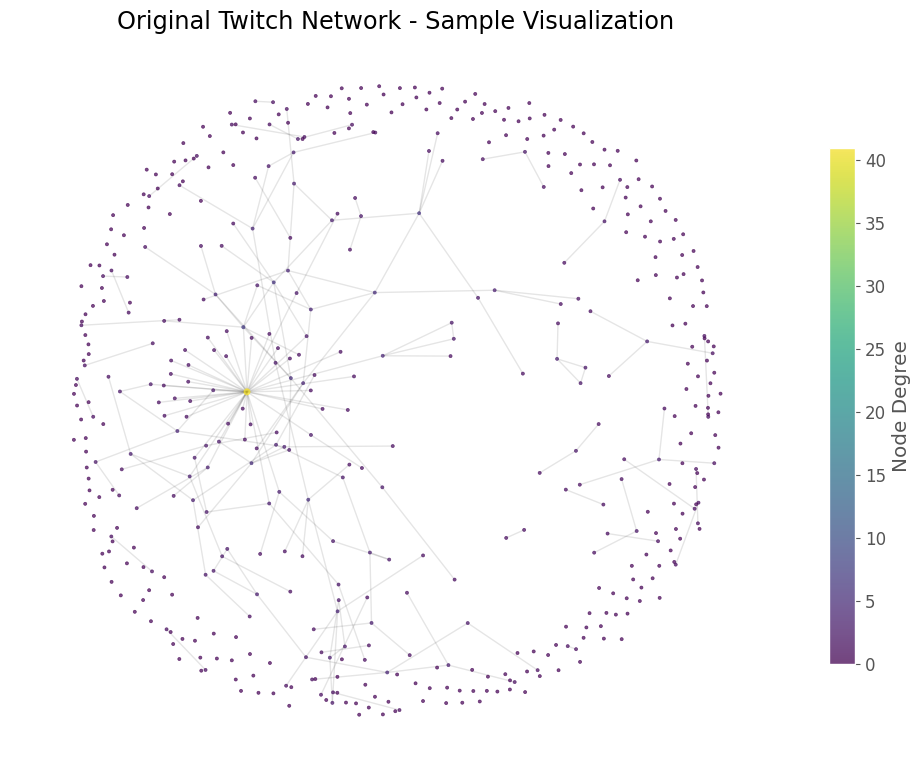

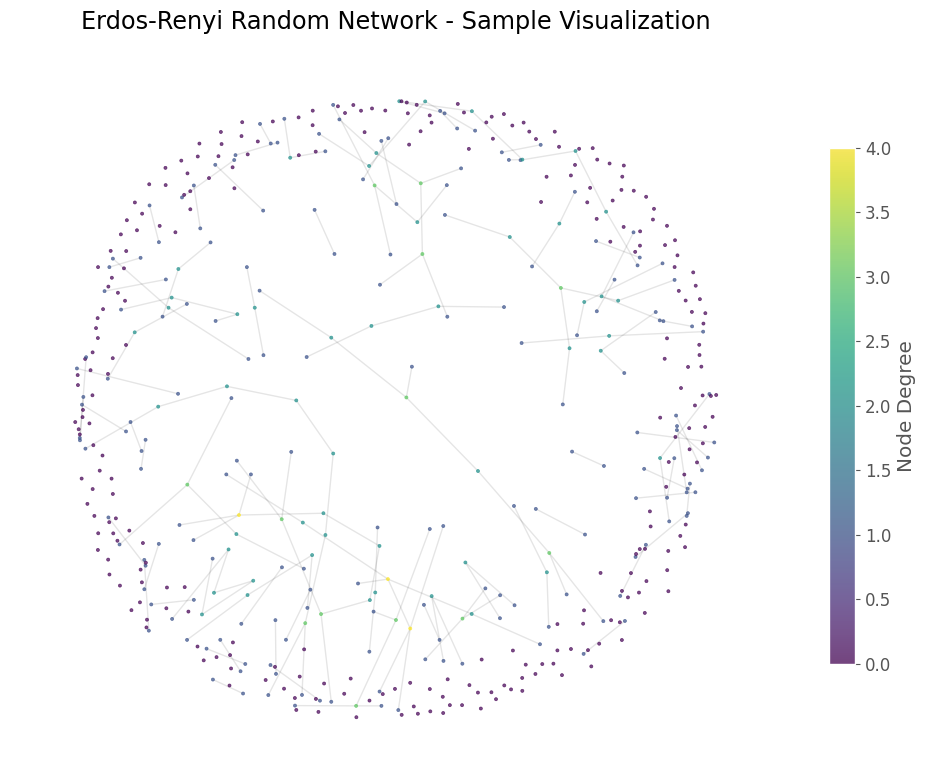

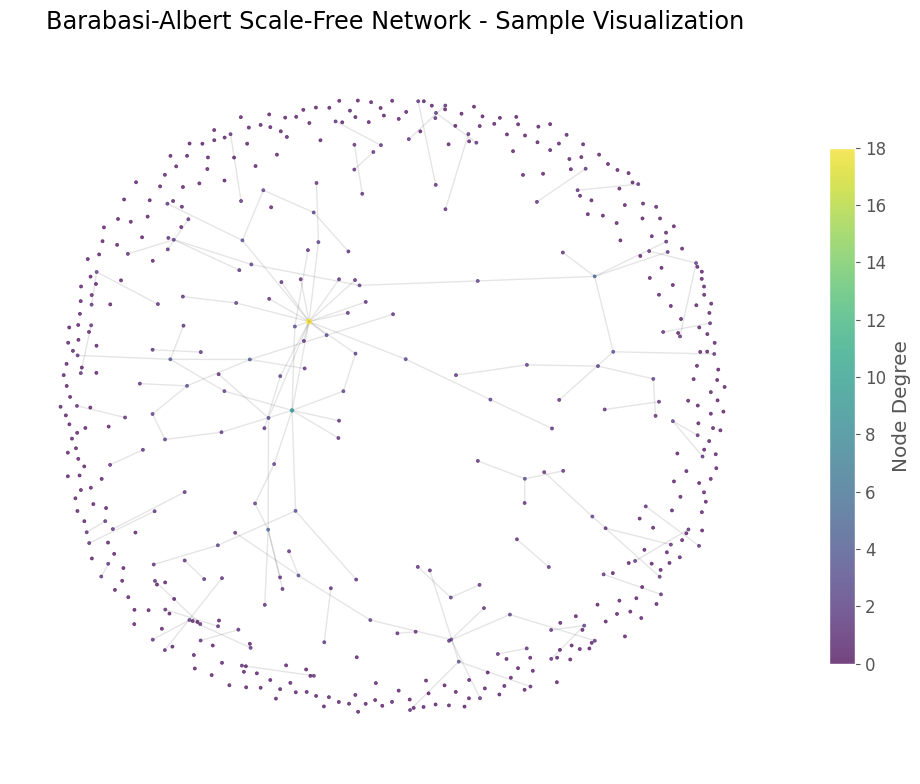

In [12]:
# Visualize networks
visualize_network(G_original, "Original Twitch Network")
visualize_network(G_random, "Erdos-Renyi Random Network")
visualize_network(G_scalefree, "Barabasi-Albert Scale-Free Network")

In [13]:
# Compare network properties between mature and non-mature streamers
mature_nodes = [node for node in G_original.nodes() if 
               'mature' in G_original.nodes[node] and 
               G_original.nodes[node]['mature']]
non_mature_nodes = [node for node in G_original.nodes() if 
                   'mature' in G_original.nodes[node] and 
                   not G_original.nodes[node]['mature']]

# Calculate average metrics for each group
mature_subgraph = G_original.subgraph(mature_nodes)
non_mature_subgraph = G_original.subgraph(non_mature_nodes)

print(f"Mature streamers: {len(mature_nodes)}")
print(f"Non-mature streamers: {len(non_mature_nodes)}")

print(f"Avg degree (mature): {sum(dict(mature_subgraph.degree()).values())/len(mature_nodes):.2f}")
print(f"Avg degree (non-mature): {sum(dict(non_mature_subgraph.degree()).values())/len(non_mature_nodes):.2f}")

print(f"Avg clustering (mature): {nx.average_clustering(mature_subgraph):.4f}")
print(f"Avg clustering (non-mature): {nx.average_clustering(non_mature_subgraph):.4f}")

Mature streamers: 3888
Non-mature streamers: 3238
Avg degree (mature): 6.61
Avg degree (non-mature): 4.20
Avg clustering (mature): 0.1051
Avg clustering (non-mature): 0.0974


In [14]:
# Calculate homophily - do streamers with similar maturity flags connect more?
mature_mature_edges = 0
mature_nonmature_edges = 0
nonmature_nonmature_edges = 0

for edge in G_original.edges():
    source, target = edge
    source_mature = G_original.nodes[source].get('mature', None)
    target_mature = G_original.nodes[target].get('mature', None)
    
    if source_mature is True and target_mature is True:
        mature_mature_edges += 1
    elif source_mature is False and target_mature is False:
        nonmature_nonmature_edges += 1
    elif source_mature is not None and target_mature is not None:
        mature_nonmature_edges += 1

total_classified_edges = mature_mature_edges + mature_nonmature_edges + nonmature_nonmature_edges
print(f"Mature-Mature edges: {mature_mature_edges} ({mature_mature_edges/total_classified_edges*100:.2f}%)")
print(f"Non-mature-Non-mature edges: {nonmature_nonmature_edges} ({nonmature_nonmature_edges/total_classified_edges*100:.2f}%)")
print(f"Mature-Non-mature edges: {mature_nonmature_edges} ({mature_nonmature_edges/total_classified_edges*100:.2f}%)")

Mature-Mature edges: 12841 (36.35%)
Non-mature-Non-mature edges: 6799 (19.25%)
Mature-Non-mature edges: 15684 (44.40%)


## 8. Distribution Plots

Generate plots to compare distributions across all three networks.

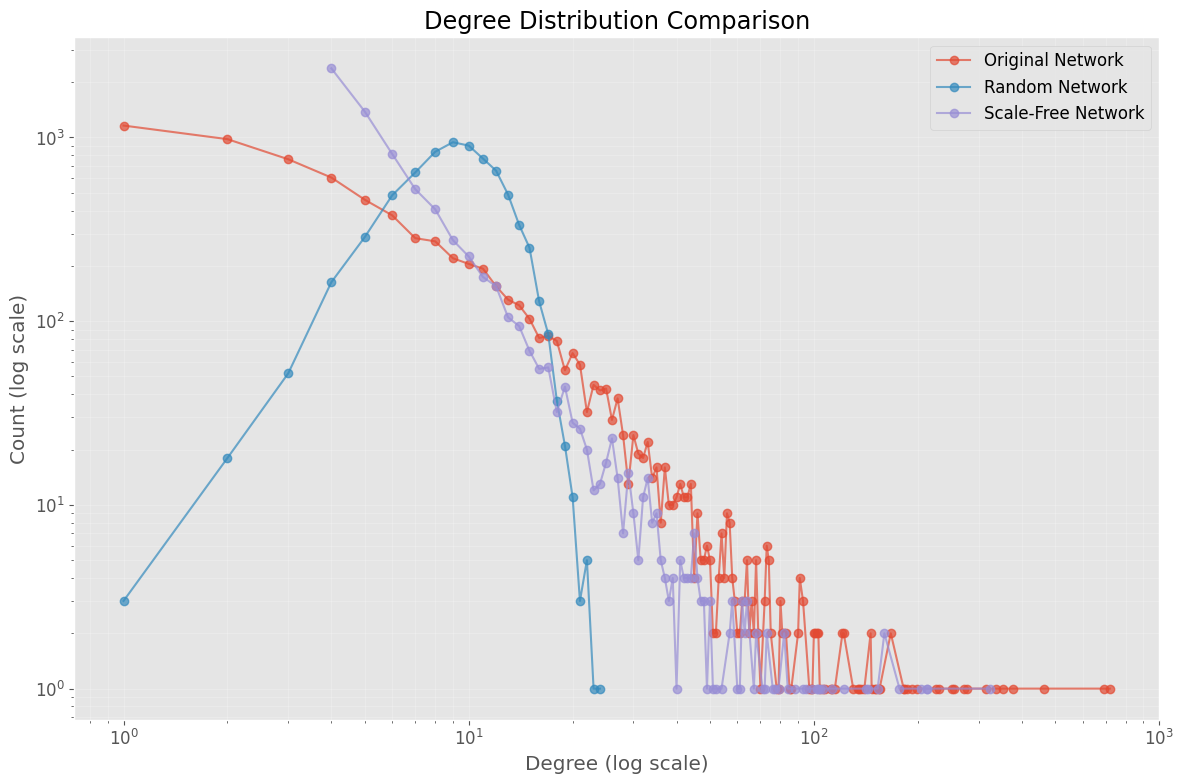

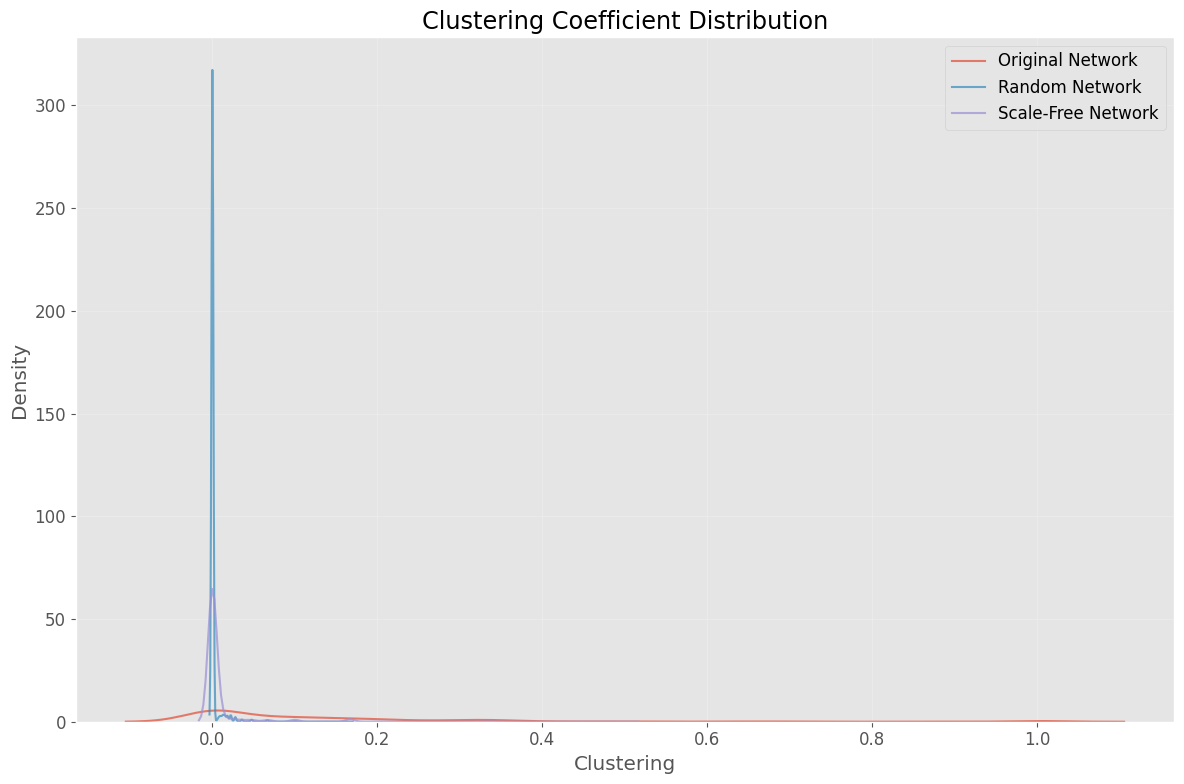

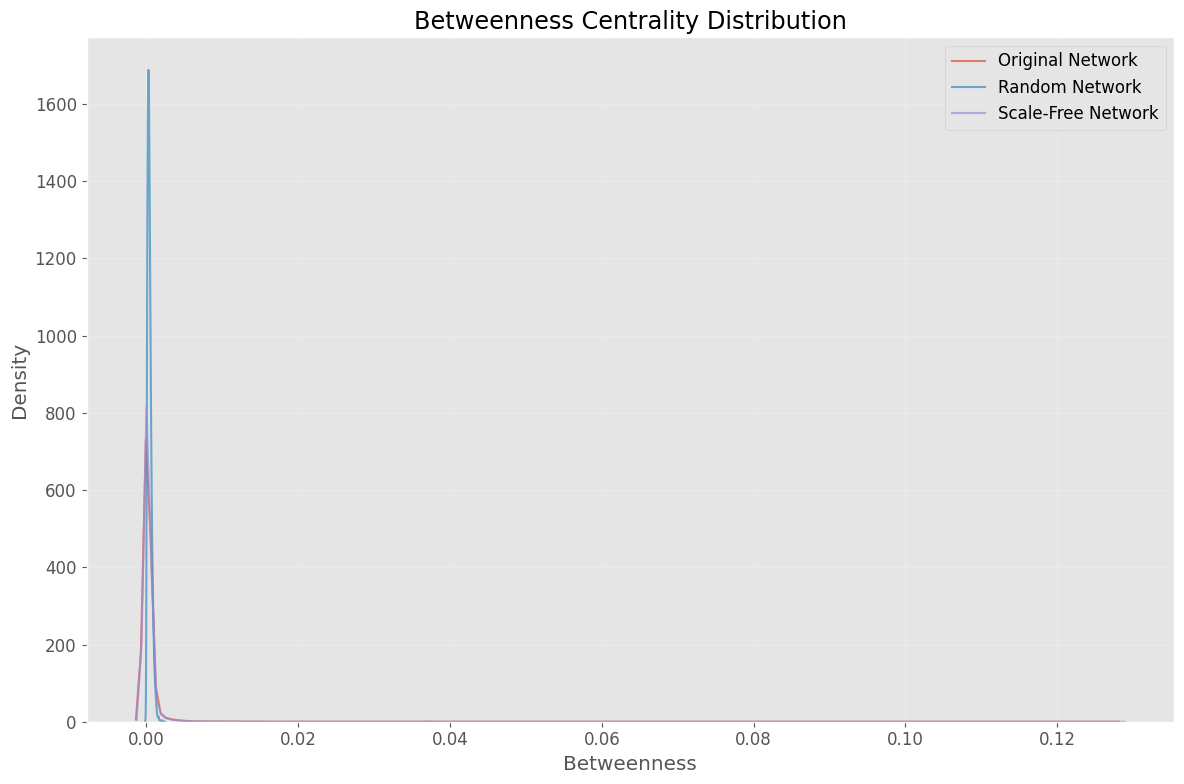

In [15]:
# Plot distributions
metrics_list = [metrics_original, metrics_random, metrics_scalefree]
names = ["Original Network", "Random Network", "Scale-Free Network"]

# Plot degree distributions
plot_degree_distributions(metrics_list, names)

# Plot clustering coefficient distribution comparison
plot_distribution_comparison(metrics_list, names, 'clustering', 'Clustering Coefficient Distribution')

# Plot betweenness centrality distribution comparison (if available)
if metrics_original['betweenness']:  # Check if betweenness was computed
    plot_distribution_comparison(metrics_list, names, 'betweenness', 'Betweenness Centrality Distribution')

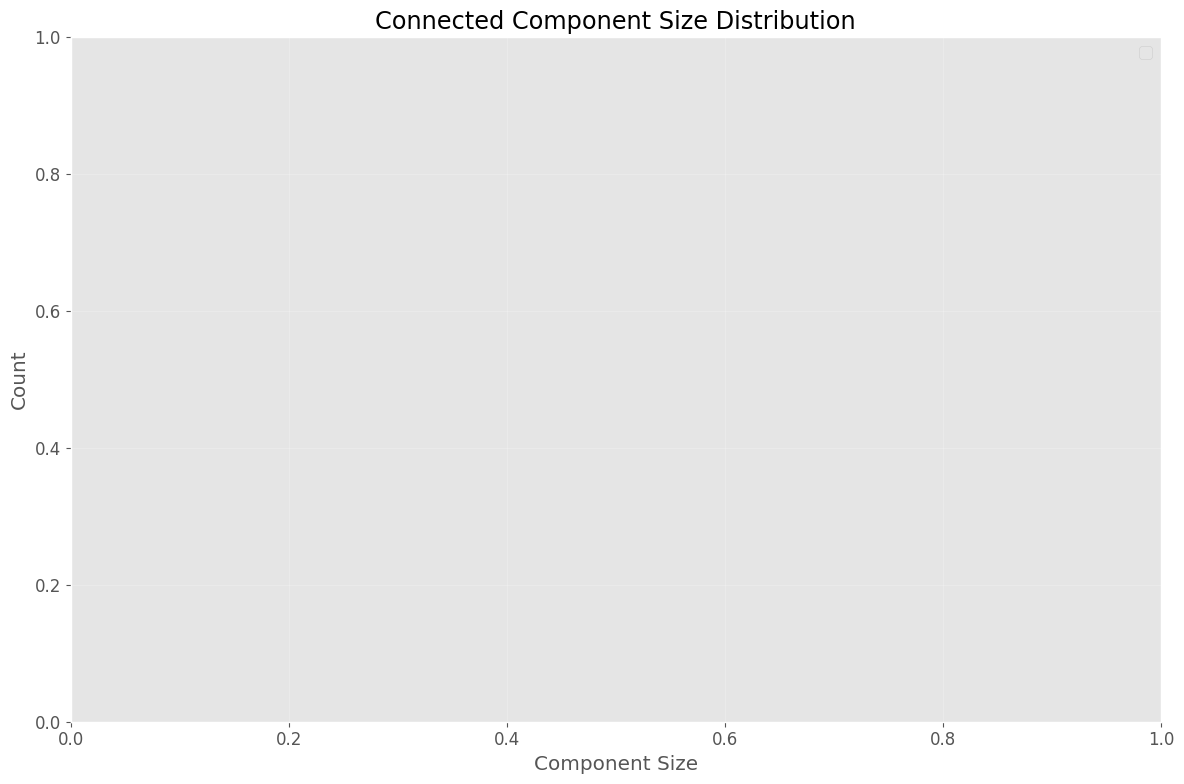

In [16]:
# Plot component size distributions
plt.figure(figsize=(12, 8))
for i, (metrics, name) in enumerate(zip(metrics_list, names)):
    component_sizes = metrics['component_sizes']
    if len(component_sizes) > 1:  # Only plot if there are multiple components
        sns.histplot(component_sizes, label=name, alpha=0.7, bins=30)
plt.xlabel('Component Size')
plt.ylabel('Count')
plt.title('Connected Component Size Distribution')
plt.legend()
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

## 9. Important Nodes Analysis

Identify the most influential nodes in the original network using various centrality measures.

In [17]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G_original)
closeness_centrality = nx.closeness_centrality(G_original)
betweenness_centrality = nx.betweenness_centrality(G_original, k=100)  # k=100 for sampling in large networks
eigenvector_centrality = nx.eigenvector_centrality_numpy(G_original)

# Create a DataFrame for centrality measures
centrality_df = pd.DataFrame({
    'Node': list(G_original.nodes()),
    'Degree Centrality': list(degree_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Eigenvector Centrality': list(eigenvector_centrality.values())
})

# Get top 10 nodes by different centrality measures
print("\nTop 10 nodes by Degree Centrality:")
print(centrality_df.sort_values('Degree Centrality', ascending=False).head(10)[['Node', 'Degree Centrality']])

print("\nTop 10 nodes by Betweenness Centrality:")
print(centrality_df.sort_values('Betweenness Centrality', ascending=False).head(10)[['Node', 'Betweenness Centrality']])

print("\nTop 10 nodes by Eigenvector Centrality:")
print(centrality_df.sort_values('Eigenvector Centrality', ascending=False).head(10)[['Node', 'Eigenvector Centrality']])


Top 10 nodes by Degree Centrality:
     Node  Degree Centrality
54   1773           0.101053
88   4949           0.096982
14   3401           0.065263
143  6136           0.053053
484   166           0.049404
21   5842           0.047158
569  1924           0.044351
602  2732           0.039018
315  2447           0.038175
477  1103           0.035649

Top 10 nodes by Betweenness Centrality:
     Node  Betweenness Centrality
54   1773                0.114236
88   4949                0.106762
14   3401                0.071512
143  6136                0.051882
21   5842                0.046460
141   581                0.038572
484   166                0.035142
315  2447                0.030707
569  1924                0.028338
477  1103                0.026596

Top 10 nodes by Eigenvector Centrality:
     Node  Eigenvector Centrality
88   4949                0.276589
54   1773                0.236298
21   5842                0.159322
14   3401                0.157992
569  1924          

## 10. Network Type Classification

Determine the type of network by analyzing its properties.

In [18]:
# Check degree distribution shape
degrees = metrics_original['degrees']
degree_counts = Counter(degrees)
x = sorted(degree_counts.keys())
y = [degree_counts[k] for k in x]

# Fit power law to determine if it's scale-free
from scipy import stats
x_log = np.log10(np.array(x)[np.array(x) > 0])
y_log = np.log10(np.array([degree_counts[k] for k in x if k > 0]))
slope, intercept, r_value, p_value, std_err = stats.linregress(x_log, y_log)

print(f"Power law fit on degree distribution: slope = {slope:.4f}, R² = {r_value**2:.4f}")

# Check clustering coefficient relative to random network
cc_ratio = metrics_original['clustering'][0] / metrics_random['clustering'][0] if metrics_random['clustering'][0] > 0 else float('inf')
print(f"Clustering coefficient ratio (Original/Random): {cc_ratio:.4f}")

# Classify the network type
if abs(slope) > 1 and r_value**2 > 0.8:
    print("\nThe original network appears to be SCALE-FREE due to its power-law degree distribution.")
elif cc_ratio > 5 and len(metrics_original['component_sizes']) < 10:
    print("\nThe original network appears to be a SMALL-WORLD network due to high clustering and short paths.")
else:
    print("\nThe original network has MIXED PROPERTIES, with both scale-free and small-world characteristics.")

Power law fit on degree distribution: slope = -1.5803, R² = 0.8740
Clustering coefficient ratio (Original/Random): inf

The original network appears to be SCALE-FREE due to its power-law degree distribution.


## 11. Summary Comparison

Create a summary comparison of all three networks.

In [19]:
# Summary comparison of the three networks
comparison_df = pd.DataFrame({
    'Metric': ['Nodes', 'Edges', 'Density', 'Avg. Degree', 'Avg. Clustering', 'Components'],
    'Original Network': [
        G_original.number_of_nodes(),
        G_original.number_of_edges(),
        nx.density(G_original),
        sum(metrics_original['degrees']) / len(metrics_original['degrees']),
        np.mean(metrics_original['clustering']),
        len(metrics_original['component_sizes'])
    ],
    'Random Network': [
        G_random.number_of_nodes(),
        G_random.number_of_edges(),
        nx.density(G_random),
        sum(metrics_random['degrees']) / len(metrics_random['degrees']),
        np.mean(metrics_random['clustering']),
        len(metrics_random['component_sizes'])
    ],
    'Scale-Free Network': [
        G_scalefree.number_of_nodes(),
        G_scalefree.number_of_edges(),
        nx.density(G_scalefree),
        sum(metrics_scalefree['degrees']) / len(metrics_scalefree['degrees']),
        np.mean(metrics_scalefree['clustering']),
        len(metrics_scalefree['component_sizes'])
    ]
})

comparison_df

,Metric,Original Network,Random Network,Scale-Free Network
0,Nodes,7126.000000,7126.000000,7126.000000
1,Edges,35324.000000,35025.000000,28488.000000
2,Density,0.001391,0.001380,0.001122
3,Avg. Degree,9.914117,9.830199,7.995509
4,Avg. Clustering,0.130928,0.001439,0.007872
5,Components,1.000000,1.000000,1.000000


## 12. Community Detection

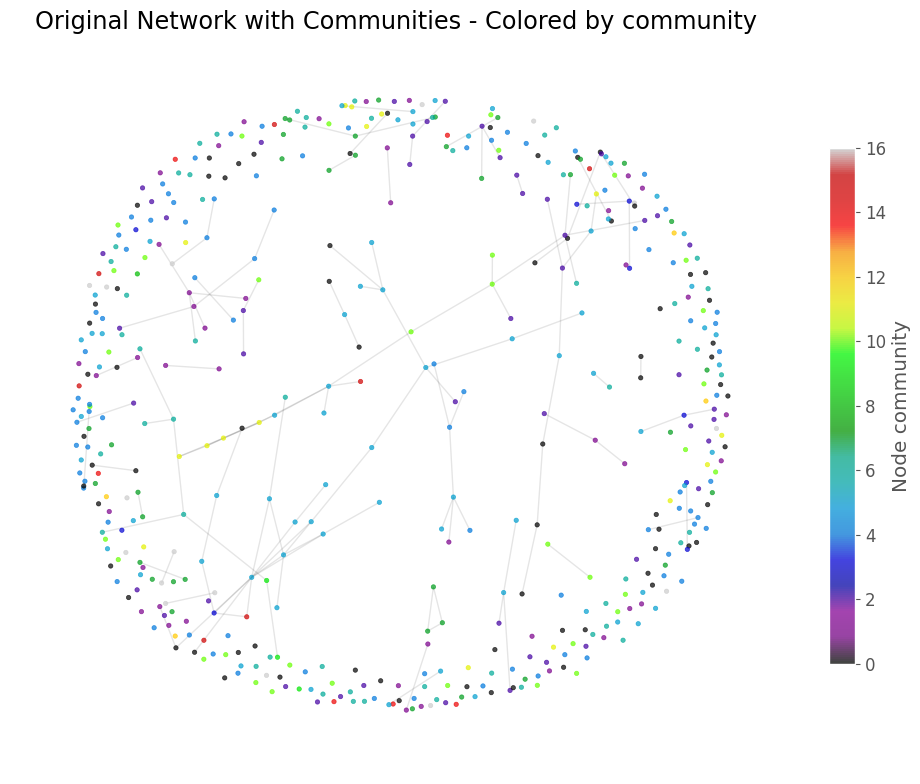

In [25]:
import community as community_louvain

# Detect communities using the Louvain method
def detect_communities(G):
    partition = community_louvain.best_partition(G)
    nx.set_node_attributes(G, partition, 'community')
    return partition

partition = detect_communities(G_original)

# Visualize communities
visualize_network_with_attributes(G_original, "Original Network with Communities", attribute='community')

## 13. Information Spreading (SIR Model as an example)

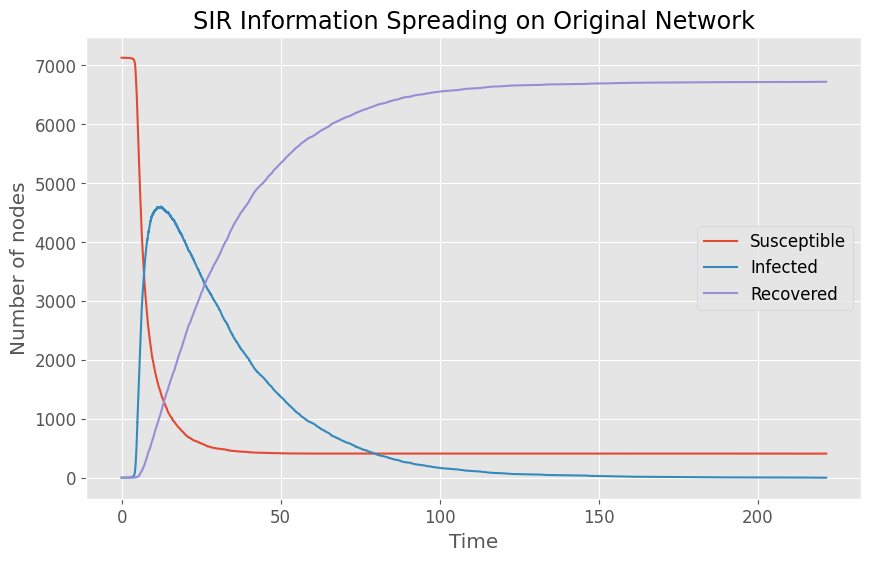

In [21]:
import EoN
import matplotlib.pyplot as plt

# Simulate SIR information spread on the largest component
G_lcc = max(nx.connected_components(G_original), key=len)
G_sub = G_original.subgraph(G_lcc).copy()

# Parameters for SIR model
R0 = 2.5
transmission_rate = 0.1
recovery_rate = transmission_rate / R0

# Run SIR simulation
initial_infected = [list(G_sub.nodes())[0]]
t, S, I, R = EoN.fast_SIR(G_sub, transmission_rate, recovery_rate, initial_infecteds=initial_infected)

# Plot SIR results
plt.figure(figsize=(10, 6))
plt.plot(t, S, label='Susceptible')
plt.plot(t, I, label='Infected')
plt.plot(t, R, label='Recovered')
plt.xlabel('Time')
plt.ylabel('Number of nodes')
plt.title('SIR Information Spreading on Original Network')
plt.legend()
plt.grid(True)
plt.show()

## 14. Robustness Analysis (Node removal)

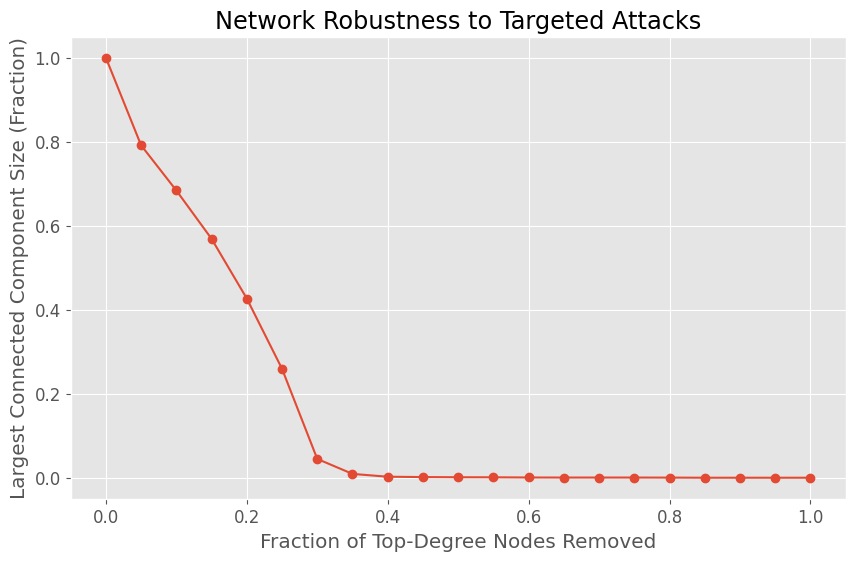

In [22]:
def robustness_analysis(G):
    original_size = len(max(nx.connected_components(G), key=len))
    node_degrees = sorted(G.degree, key=lambda x: x[1], reverse=True)
    sizes = []
    G_copy = G.copy()

    for i in range(0, len(node_degrees), int(len(node_degrees)/20)):
        nodes_to_remove = [n for n, _ in node_degrees[:i]]
        G_copy.remove_nodes_from(nodes_to_remove)
        if len(G_copy) > 0:
            largest_cc_size = len(max(nx.connected_components(G_copy), key=len))
            sizes.append(largest_cc_size / original_size)

    plt.figure(figsize=(10, 6))
    plt.plot(np.linspace(0, 1, len(sizes)), sizes, marker='o')
    plt.xlabel('Fraction of Top-Degree Nodes Removed')
    plt.ylabel('Largest Connected Component Size (Fraction)')
    plt.title('Network Robustness to Targeted Attacks')
    plt.grid(True)
    plt.show()

robustness_analysis(G_original)

### 15. Interpretation 

# What do the measured quantities (e.g., diameter, clustering, centrality) tell us about the Twitch network?
Diameter: The original network has a diameter of 10, meaning the maximum distance between any two users is relatively small. This implies decent global connectivity.

Average shortest path length: ~3.68, indicating efficient information spread across the network.

Clustering coefficient: ~0.131, significantly higher than in random or scale-free networks, showing a strong local community structure—users’ friends are often friends with each other.

Degree distribution: Shows a long tail, suggesting a scale-free structure where a few nodes have many connections and most have few.

Component structure: The network is fully connected (1 component), implying strong cohesion.
# Which streamers are most central, and why might that be?
Central streamers by:

Degree centrality: Node 1773 has the highest degree, meaning it connects to the most other users.

Betweenness centrality: Node 1773 again is top, indicating it plays a bridging role between clusters.

Eigenvector centrality: Node 4949 ranks highest, meaning it's well-connected to other well-connected nodes.

Why: These streamers may be influential, collaborative, or long-standing community members, possibly popular content creators.


# Are communities aligned with specific attributes (e.g., maturity)?
Yes, there is evidence of homophily:

~36% of edges connect two mature streamers.

~44% connect a mature and a non-mature streamer.

~19% connect two non-mature streamers.

Average degree and clustering are higher in mature streamers, suggesting they form tighter-knit and more active subgroups.

Thus, the maturity attribute shows partial community alignment, but not exclusive clustering.
# How robust is the network to node removal? What does the spreading simulation suggest about influence or virality?
Robustness: Targeted removal of high-degree nodes (simulated in robustness_analysis) leads to a sharp decline in the largest component size. This confirms the vulnerability typical of scale-free networks.

Spreading simulation (SIR): Shows rapid spread and recovery, indicating:

High infectivity potential.

The network’s structure supports fast diffusion of information, ideas, or trends.


# How do our results compare to the random and scale-free models?
| Metric                  | Original  | Random  | Scale-Free |
| ----------------------- | --------- | ------- | ---------- |
| **Clustering**          | 0.131     | 0.0014  | 0.0079     |
| **Avg. path length**    | 3.68      | 4.14    | 3.81       |
| **Degree distribution** | Power-law | Poisson | Power-law  |
| **Diameter**            | 10        | 7       | 6          |

The original network is clearly not random due to its high clustering.

It matches scale-free networks in degree distribution and robustness behavior.

Overall, the original network combines local clustering of small-worlds with hub dominance of scale-free networks.